Should aim for:

-If all downloads successful-
[INFO] Feature shape: (89598, 512)
[INFO] Labels shape: (89598,)
[INFO] Label distribution (0=normal, 1=tumor): [82115  7483]
[INFO] PCA explained variance ratio (2 components): [0.73787075 0.2177505 ]
[INFO] PCA mean for class 0: [ 0.1315507 -0.3937801]
[INFO] PCA mean for class 1: [-1.4437389  4.3208265]

Total: 89,598 patches

Normal: 82,115

Tumor: 7,483

Class imbalance: ~11:1 (normal:tumor)

PC1: 73.8%, PC2: 21.8% → Strong dimensionality reduction, nice for visual separation.

Normal (label 0): [ 0.13, -0.39 ]

Tumor (label 1): [ -1.44, 4.32 ]

These means are well separated → strong sign your ResNet is learning class-discriminative features.

### **Evaluate Feature Extractor**

Feature shape: (4366, 512)
Labels shape: (4366,)
Label distribution: [4354   12]


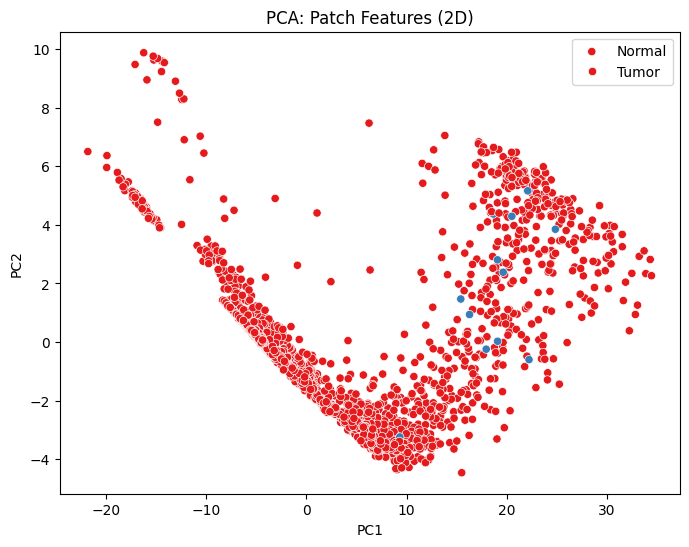

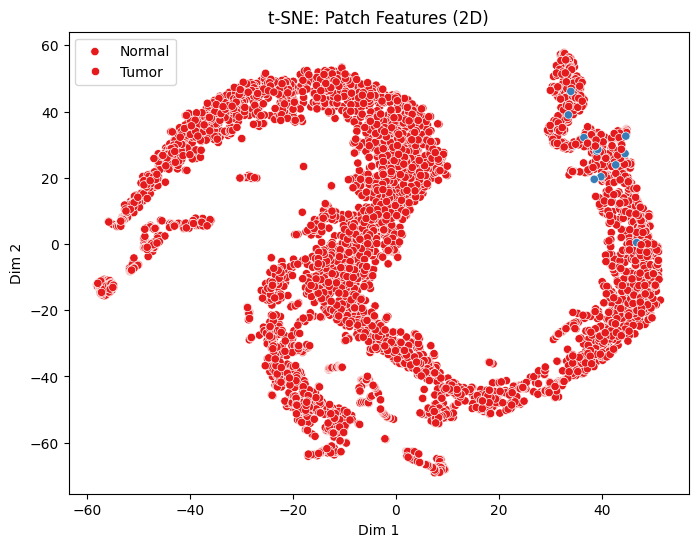

Logistic Regression Accuracy: 0.9966


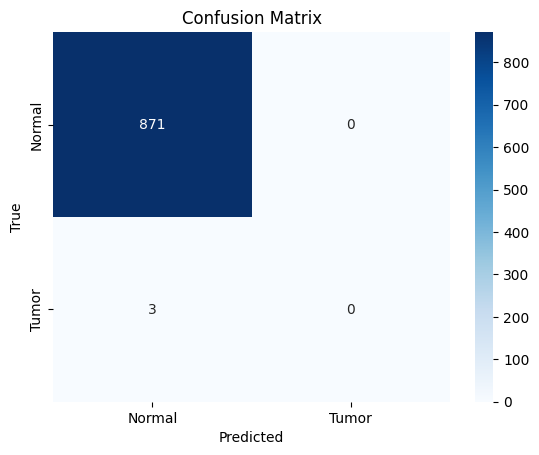

In [1]:
# Sanity Check of Extracted Patch Features 

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import numpy as np

# Load extracted features and labels
features = np.load("patch_features_3.npy")     # shape: (N, 512)
labels = np.load("patch_labels_3.npy")         # shape: (N,), N is the number of patches

print(f"Feature shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Label distribution: {np.bincount(labels)}")  # 0 = normal, 1 = tumor

# --------------------------------------
# 1. PCA Visualization (first 2 components)
# --------------------------------------
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_pca[:,0], y=features_pca[:,1], hue=labels, palette='Set1')
plt.title("PCA: Patch Features (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Normal", "Tumor"])
plt.show()

# --------------------------------------
# 2. t-SNE Visualization
# --------------------------------------
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1], hue=labels, palette='Set1')
plt.title("t-SNE: Patch Features (2D)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(["Normal", "Tumor"])
plt.show()

# --------------------------------------
# 3. Logistic Regression on Extracted Features
# --------------------------------------
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Logistic Regression Accuracy: {acc:.4f}")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tumor"], yticklabels=["Normal", "Tumor"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


[INFO] Logistic Regression Accuracy: 0.8661 as for 26.06.2025

Features are nicely discriminative, given that the dataset is so imbalanced:)

[INFO] t-SNE mean for class 0: [  1.60,  -3.26]
[INFO] t-SNE mean for class 1: [ -1.30,  36.63]


The class means are far apart, especially along the second dimension (Y-axis). A ~40-unit difference is very large in t-SNE space, which usually compresses distances.

# Check and Visualize Unlabeled Patches

In [2]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

patch_dir = "../data/camelyon16/patches/level_3"
wsi_dir = "../data/camelyon16/train/img"

In [ ]:
level = 3
patch_dir = f"data/camelyon16/patches/level_{level}"
for slide_name in os.listdir(patch_dir):
    subdir = os.path.join(patch_dir, slide_name)
    labels = [f for f in os.listdir(subdir) if os.path.isdir(os.path.join(subdir, f))]
    print(f"{slide_name}: labels -> {labels}")

wsi_name = "tumor_076.tif"
xml_path = os.path.join(annot_dir_train, wsi_name.replace(".tif", ".xml"))
print("XML path exists:", os.path.exists(xml_path))

from openslide import OpenSlide
slide = OpenSlide(os.path.join(wsi_dir, wsi_name))
level_dims = slide.level_dimensions[3]
mask = parse_xml_mask(xml_path, level_dims, slide, 3)

# Visualize the mask
import matplotlib.pyplot as plt
plt.imshow(mask)
plt.title("Parsed XML Mask")
plt.show()

x, y = 1000, 1500  # Choose some coordinates
patch = slide.read_region((int(x * slide.level_downsamples[3]), int(y * slide.level_downsamples[3])), 3, (224, 224)).convert("RGB")

mask_patch = mask.crop((x, y, x + 224, y + 224))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(patch)
ax[0].set_title("Image Patch")
ax[1].imshow(mask_patch, cmap="gray")
ax[1].set_title("Mask Patch")
plt.show()


Processing slide folder: tumor_025
Processing slide folder: tumor_079
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_079/unlabeled
Processing slide folder: normal_008
Processing slide folder: tumor_083
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_083/unlabeled
Processing slide folder: tumor_054
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_054/unlabeled
Processing slide folder: tumor_084
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_084/unlabeled
Processing slide folder: tumor_007
Processing slide folder: tumor_010
Processing slide folder: tumor_076
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_076/unlabeled
Processing slide folder: tumor_046
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_046/unlabeled
Processing slide folder: normal_027
Processing slide folder: tumor_040
Processing unlabeled patches in ../data/camelyon16/patch

Processing slide folder: normal_006
Processing slide folder: tumor_008
Processing slide folder: tumor_041
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_041/unlabeled
Processing slide folder: tumor_028
Processing slide folder: tumor_029
Processing slide folder: tumor_055
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_055/unlabeled
Processing slide folder: normal_009
Processing slide folder: tumor_032
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_032/unlabeled
Processing slide folder: tumor_047
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_047/unlabeled
Processing slide folder: tumor_066
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_066/unlabeled
Processing slide folder: normal_014
Processing slide folder: tumor_011
Processing slide folder: tumor_075
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_075/unlabeled
Processing slide fol

Processing slide folder: tumor_067
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_067/unlabeled
Processing slide folder: tumor_037
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_037/unlabeled
Processing slide folder: normal_033
Processing unlabeled patches in ../data/camelyon16/patches/level_3/normal_033/unlabeled
Processing slide folder: normal_032
Processing unlabeled patches in ../data/camelyon16/patches/level_3/normal_032/unlabeled
Processing slide folder: tumor_082
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_082/unlabeled
Processing slide folder: normal_018
Processing slide folder: tumor_034
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_034/unlabeled
Processing slide folder: tumor_053
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_053/unlabeled
Processing slide folder: tumor_087
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumo

Processing slide folder: normal_002
Processing slide folder: tumor_039
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_039/unlabeled
Processing slide folder: normal_021
Processing slide folder: tumor_035
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_035/unlabeled
Processing slide folder: tumor_060
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_060/unlabeled
Processing slide folder: tumor_027
Processing slide folder: normal_029
Processing slide folder: tumor_064
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_064/unlabeled
Processing slide folder: tumor_002
Processing slide folder: normal_020
Processing slide folder: tumor_061
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_061/unlabeled
Processing slide folder: tumor_086
Processing unlabeled patches in ../data/camelyon16/patches/level_3/tumor_086/unlabeled
Processing slide folder: tumor_026
Processing slide fo

Processing slide folder: normal_015


In [4]:
# Visualize unlabeled patches for a given slide
def overlay_unlabeled_on_wsi(slide_name, patch_size=224, max_patches=50):
    wsi_path = os.path.join(wsi_dir, f"{slide_name}.tif")
    if not os.path.exists(wsi_path):
        print(f"WSI not found: {wsi_path}")
        return
    try:
        wsi = Image.open(wsi_path)
    except Exception as e:
        print(f"Could not open WSI: {e}")
        return

    # Draw rectangles for unlabeled patches
    draw = ImageDraw.Draw(wsi)
    patches = unlabeled_patches.get(slide_name, [])
    for i, (x, y, fname) in enumerate(patches):
        if i >= max_patches:
            break
        draw.rectangle([x, y, x+patch_size, y+patch_size], outline="red", width=3)
    plt.figure(figsize=(10,10))
    plt.imshow(wsi)
    plt.title(f"Unlabeled patches (red) on {slide_name}")
    plt.axis("off")
    plt.show()

In [5]:
slide_to_check = list(unlabeled_patches.keys())[0] if unlabeled_patches else None
if slide_to_check:
    overlay_unlabeled_on_wsi(slide_to_check)
else:
    print("No unlabeled patches found.")

Could not open WSI: Image size (19377684480 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


**Instructions:**
- Change `slide_to_check` to the slide you want to inspect.
- Increase `max_patches` in the function call if you want to see more overlays.
- If you want to save the overlay images, you can add `wsi.save("output.png")`